In [1]:
# Import necessary libraries
import matplotlib.pyplot as plt
import numpy as np
import gymnasium as gym
from gymnasium.envs.toy_text.cliffwalking import CliffWalkingEnv
from gymnasium.error import DependencyNotInstalled
from os import path
import io
from PIL import Image

In [2]:
UP = 0
RIGHT = 1
DOWN = 2
LEFT = 3

ACTIONS = [UP, RIGHT, DOWN, LEFT] 

MAX_CELL = 48

P_PROB = 2/3
Q_PROB = 1/6
image_path = path.join(path.dirname(gym.__file__), "envs", "toy_text")

In [3]:
class CliffWalking(CliffWalkingEnv):
    def __init__(self, is_hardmode=True, num_cliffs=10, *args, **kwargs):
        super().__init__(*args, **kwargs)
        self.is_hardmode = is_hardmode

        # Generate random cliff positions
        if self.is_hardmode:
            self.num_cliffs = num_cliffs
            self._cliff = np.zeros(self.shape, dtype=bool)
            self.start_state = (3, 0)
            self.terminal_state = (self.shape[0] - 1, self.shape[1] - 1)
            self.cliff_positions = []
            CONSTANT_POSITIONS = [(1, 5), (1, 8), (2, 1), (2, 2), (2, 6), (2, 7), (2, 9), (3, 1), (3, 3), (3, 9)]
            CLIFF_I = 0
            while len(self.cliff_positions) < self.num_cliffs:
                # new_row = np.random.randint(0, 4)
                # new_col = np.random.randint(0, 11)
                new_row, new_col = CONSTANT_POSITIONS[CLIFF_I]
                CLIFF_I += 1
                state = (new_row, new_col)
                if (
                    (state not in self.cliff_positions)
                    and (state != self.start_state)
                    and (state != self.terminal_state)
                ):
                    self._cliff[new_row, new_col] = True
                    if not self.is_valid():
                        self._cliff[new_row, new_col] = False
                        continue
                    self.cliff_positions.append(state)

        # Calculate transition probabilities and rewards
        self.P = {}
        for s in range(self.nS):
            position = np.unravel_index(s, self.shape)
            self.P[s] = {a: [] for a in range(self.nA)}
            self.P[s][UP] = self._calculate_transition_prob(position, [-1, 0])
            self.P[s][RIGHT] = self._calculate_transition_prob(position, [0, 1])
            self.P[s][DOWN] = self._calculate_transition_prob(position, [1, 0])
            self.P[s][LEFT] = self._calculate_transition_prob(position, [0, -1])

    def _calculate_transition_prob(self, current, delta):
        new_position = np.array(current) + np.array(delta)
        new_position = self._limit_coordinates(new_position).astype(int)
        new_state = np.ravel_multi_index(tuple(new_position), self.shape)
        if self._cliff[tuple(new_position)]:
            return [(1.0, self.start_state_index, -100, False)]

        terminal_state = (self.shape[0] - 1, self.shape[1] - 1)
        is_terminated = tuple(new_position) == terminal_state
        return [(1 / 3, new_state, -1, is_terminated)]

    # DFS to check that it's a valid path.
    def is_valid(self):
        frontier, discovered = [], set()
        frontier.append((3, 0))
        while frontier:
            r, c = frontier.pop()
            if not (r, c) in discovered:
                discovered.add((r, c))
                directions = [(1, 0), (0, 1), (-1, 0), (0, -1)]
                for x, y in directions:
                    r_new = r + x
                    c_new = c + y
                    if r_new < 0 or r_new >= self.shape[0] or c_new < 0 or c_new >= self.shape[1]:
                        continue
                    if (r_new, c_new) == self.terminal_state:
                        return True
                    if not self._cliff[r_new][c_new]:
                        frontier.append((r_new, c_new))
        return False

    def step(self, action):
        if action not in [0, 1, 2, 3]:
            raise ValueError(f"Invalid action {action}   must be in [0, 1, 2, 3]")

        if self.is_hardmode:
            match action:
                case 0:
                    action = np.random.choice([0, 1, 3], p=[P_PROB, Q_PROB, Q_PROB])
                case 1:
                    action = np.random.choice([0, 1, 2], p=[Q_PROB, P_PROB, Q_PROB])
                case 2:
                    action = np.random.choice([1, 2, 3], p=[Q_PROB, P_PROB, Q_PROB])
                case 3:
                    action = np.random.choice([0, 2, 3], p=[Q_PROB, Q_PROB, P_PROB])

        return super().step(action)

    def _render_gui(self, mode):
        try:
            import pygame
        except ImportError as e:
            raise DependencyNotInstalled(
                "pygame is not installed, run `pip install gymnasium[toy-text]`"
            ) from e
        if self.window_surface is None:
            pygame.init()

            if mode == "human":
                pygame.display.init()
                pygame.display.set_caption("CliffWalking")
                self.window_surface = pygame.display.set_mode(self.window_size)
            else:  # rgb_array
                self.window_surface = pygame.Surface(self.window_size)
        if self.clock is None:
            self.clock = pygame.time.Clock()
        if self.elf_images is None:
            hikers = [
                path.join(image_path, "img/elf_up.png"),
                path.join(image_path, "img/elf_right.png"),
                path.join(image_path, "img/elf_down.png"),
                path.join(image_path, "img/elf_left.png"),
            ]
            self.elf_images = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in hikers
            ]
        if self.start_img is None:
            file_name = path.join(image_path, "img/stool.png")
            self.start_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.goal_img is None:
            file_name = path.join(image_path, "img/cookie.png")
            self.goal_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )
        if self.mountain_bg_img is None:
            bg_imgs = [
                path.join(image_path, "img/mountain_bg1.png"),
                path.join(image_path, "img/mountain_bg2.png"),
            ]
            self.mountain_bg_img = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in bg_imgs
            ]
        if self.near_cliff_img is None:
            near_cliff_imgs = [
                path.join(image_path, "img/mountain_near-cliff1.png"),
                path.join(image_path, "img/mountain_near-cliff2.png"),
            ]
            self.near_cliff_img = [
                pygame.transform.scale(pygame.image.load(f_name), self.cell_size)
                for f_name in near_cliff_imgs
            ]
        if self.cliff_img is None:
            file_name = path.join(image_path, "img/mountain_cliff.png")
            self.cliff_img = pygame.transform.scale(
                pygame.image.load(file_name), self.cell_size
            )

        for s in range(self.nS):
            row, col = np.unravel_index(s, self.shape)
            pos = (col * self.cell_size[0], row * self.cell_size[1])
            check_board_mask = row % 2 ^ col % 2
            self.window_surface.blit(self.mountain_bg_img[check_board_mask], pos)

            if self._cliff[row, col]:
                self.window_surface.blit(self.cliff_img, pos)
            if s == self.start_state_index:
                self.window_surface.blit(self.start_img, pos)
            if s == self.nS - 1:
                self.window_surface.blit(self.goal_img, pos)
            if s == self.s:
                elf_pos = (pos[0], pos[1] - 0.1 * self.cell_size[1])
                last_action = self.lastaction if self.lastaction is not None else 2
                self.window_surface.blit(self.elf_images[last_action], elf_pos)

        if mode == "human":
            pygame.event.pump()
            pygame.display.update()
            self.clock.tick(self.metadata["render_fps"])
        else:  # rgb_array
            return np.transpose(
                np.array(pygame.surfarray.pixels3d(self.window_surface)), axes=(1, 0, 2)
            )

In [4]:
def draw_grid(directions, no_arrow_positions=[], ax=None):
    rows = 4
    columns = 12
    cell_size = 1

    # Create a new figure/axes if not provided.
    if ax is None:
        fig, ax = plt.subplots()

    # Clear the axis
    ax.clear()

    for row in range(rows):
        for col in range(columns):
            index = row * columns + col
            direction = directions.get(index, None)

            if direction is not None and index not in no_arrow_positions:
                x = col * cell_size + cell_size / 2
                y = (rows - 1 - row) * cell_size + cell_size / 2

                if direction == 0:  # Upward arrow
                    ax.arrow(x, y, 0, cell_size / 4, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 1:  # Right arrow
                    ax.arrow(x, y, cell_size / 4, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 2:  # Downward arrow
                    ax.arrow(x, y, 0, -cell_size / 4, head_width=0.2, head_length=0.2, fc='black', ec='black')
                elif direction == 3:  # Left arrow
                    ax.arrow(x, y, -cell_size / 4, 0, head_width=0.2, head_length=0.2, fc='black', ec='black')
            elif index in no_arrow_positions:
                c = 'black'
                if index == 47:
                    c = 'green'
                ax.add_patch(plt.Rectangle((col, rows - 1 - row), 1, 1, color=c))

    ax.set_aspect('equal')
    ax.set_xlim(0, columns)
    ax.set_ylim(0, rows)
    ax.set_xticks([])
    ax.set_yticks([])

In [5]:
import matplotlib.pyplot as plt
import matplotlib.colors as mcolors

def draw_values(data, cell_width=2, cell_height=2, ax=None, cmap='coolwarm'):
    """
    Draws a grid of values as a heatmap with text annotations using improved colors.
    
    Parameters:
        data (dict): Dictionary mapping state indices (0 to 47) to values.
        cell_width (float): Width scaling factor for the figure if ax is not provided.
        cell_height (float): Height scaling factor for the figure if ax is not provided.
        ax (matplotlib.axes.Axes, optional): An axes object to draw on. If None, a new
                                               figure and axes are created.
        cmap (str or Colormap): Colormap to use for the heatmap. Default is 'coolwarm'.
    """
    # Prepare data for plotting: create a 4x12 grid.
    values = [data.get(i, 0) for i in range(48)]
    grid_values = [values[i:i+12] for i in range(0, len(values), 12)]
    
    # Create a new figure and axis if one isn't provided.
    if ax is None:
        fig, ax = plt.subplots(figsize=(12 * cell_width, 4 * cell_height))
    else:
        ax.clear()
    
    # Draw the heatmap using the specified colormap.
    im = ax.imshow(grid_values, cmap=cmap, interpolation='nearest')
    
    # Add text annotations with values formatted to 3 decimal places.
    rows, cols = 4, 12
    for i in range(rows):
        for j in range(cols):
            value = grid_values[i][j]
            # Get the RGBA color from the colormap.
            rgba = im.cmap(im.norm(value))
            # Compute brightness using the luminance formula.
            brightness = 0.299 * rgba[0] + 0.587 * rgba[1] + 0.114 * rgba[2]
            # Choose white text on dark backgrounds and black text on light ones.
            text_color = 'white' if brightness < 0.5 else 'black'
            ax.text(j, i, '{:.3f}'.format(value),
                    ha='center', va='center', color=text_color, fontsize=12)
    
    # Customize plot aesthetics.
    ax.set_title('Grid Visualization', fontsize=16, pad=10)
    ax.set_xticks(range(cols))
    ax.set_yticks(range(rows))
    ax.set_xlabel('Columns', fontsize=14)
    ax.set_ylabel('Rows', fontsize=14)
    ax.grid(False)
    
    # Add a colorbar attached to the axis.
    plt.colorbar(im, ax=ax, label='Values')


In [6]:
class Agent: 
    def __init__(self, env, discount_factor=0.9, REWARD=(10000, -100, -1), PROB=(1/3, 1/3), mx_itr=(50, 500, 10000)):
        self.env = env
        self.discount_factor = discount_factor
        self.REWARD = REWARD          # REWARD[0]: goal, REWARD[1]: cliff, REWARD[2]: step cost
        self.PROB = PROB              # PROB[0]: intended move, PROB[1]: lateral moves (each)
        self.mx_itr = mx_itr          # (policy_iteration, policy_evaluation, value_iteration) max iterations
        self.initialize()

    def get_s_pos(self, s):
        """Convert state index to (row, col)."""
        r = s // 12
        c = s % 12
        return (r, c)
    
    def get_s_cell(self, s):
        """Convert a (row, col) tuple to state index."""
        return s[0] * 12 + s[1]
    
    def actions(self, s):
        """Return the list of available actions at state s.
           Note: Terminal states will not be updated, so this is used only for non‐terminal states."""
        pos_r, pos_c = self.get_s_pos(s)
        A = []
        if pos_r != 0:
            A.append(UP)
        if pos_r != 3:
            A.append(DOWN)
        if pos_c != 0:
            A.append(LEFT)
        if pos_c != 11:
            A.append(RIGHT)
        return A

    def T(self, s, a):
        """Build the transition function for state s and action a.
           Returns a list of tuples (probability, next_state, reward)."""
        S = []
        res = self.result(s, a)
        # Assumes exactly three outcomes: intended and two lateral moves.
        for i, sp in enumerate(res):
            if i == 0:
                S.append((self.PROB[0], sp, self.REWARD[2]))
            else:
                S.append((self.PROB[1], sp, self.REWARD[2]))
        return S
    
    def result_definite(self, s, a):
        """Returns the resulting state index when taking action a deterministically from state s."""
        action_mapping = {UP: -12, RIGHT: 1, DOWN: 12, LEFT: -1}
        return s + action_mapping[a]
    
    def result(self, s, a):
        """Returns a list of three outcomes from state s when taking action a,
           with the intended move first and two lateral moves second.
           (If the lateral move is not available, the state remains unchanged.)"""
        pos_r, pos_c = self.get_s_pos(s)
        res = []
        # Intended move:
        res.append(self.result_definite(s, a))
        
        if a == UP:
            # Lateral alternatives: RIGHT and LEFT
            if pos_c != 11:
                res.append(self.result_definite(s, RIGHT))
            else:
                res.append(s)
            if pos_c != 0:
                res.append(self.result_definite(s, LEFT))
            else:
                res.append(s)
        elif a == RIGHT:
            # Alternatives: UP and DOWN
            if pos_r != 0:
                res.append(self.result_definite(s, UP))
            else:
                res.append(s)
            if pos_r != 3:
                res.append(self.result_definite(s, DOWN))
            else:
                res.append(s)
        elif a == LEFT:
            # Alternatives: UP and DOWN
            if pos_r != 0:
                res.append(self.result_definite(s, UP))
            else:
                res.append(s)
            if pos_r != 3:
                res.append(self.result_definite(s, DOWN))
            else:
                res.append(s)
        elif a == DOWN:
            # Alternatives: RIGHT and LEFT
            if pos_c != 11:
                res.append(self.result_definite(s, RIGHT))
            else:
                res.append(s)
            if pos_c != 0:
                res.append(self.result_definite(s, LEFT))
            else:
                res.append(s)
        return res
    
    def initialize(self):
        """Precompute the environment transitions for every state and action."""
        my_env = {}
        for state in range(MAX_CELL):
            my_env[state] = {}
            for action in self.actions(state):
                my_env[state][action] = []
                for transition in self.T(state, action):
                    my_env[state][action].append(transition)
        self.my_env = my_env
        
    def value_iteration(self):
        """Perform value iteration with convergence stopping criteria.
           Terminal states (goal and cliff) are not updated."""
        history = []
        # Initialize v for all states.
        v = {s: 0 for s in range(MAX_CELL)}
        p = {}  # optimal policy
        q = {}
        # Identify terminal states.
        cliff_states = set(self.get_s_cell(x) for x in self.env.cliff_positions)
        terminal_states = set([47]) | cliff_states

        # Set terminal state values.
        for s in terminal_states:
            v[s] = self.REWARD[0] if s == 47 else self.REWARD[1]

        t = 0
        while t < self.mx_itr[2]:
            delta = 0
            new_v = v.copy()
            new_p = p.copy()
            q = {}
            for s in range(MAX_CELL):
                if s in terminal_states:
                    continue
                q[s] = {}
                for a in self.actions(s):
                    q_val = 0
                    for prob, sp, reward in self.my_env[s][a]:
                        q_val += prob * (reward + self.discount_factor * v[sp])
                    q[s][a] = q_val
                best_action = max(q[s], key=q[s].get)
                best_val = q[s][best_action]
                new_v[s] = best_val
                new_p[s] = best_action
                delta = max(delta, abs(new_v[s] - v[s]))
            v = new_v
            p.update(new_p)
            history.append((p.copy(), v.copy()))
            t += 1
            if delta < 0.0001:
                break
                        
        return p, v, q, t, history

    def policy_evaluation(self, p):
        """Perform policy evaluation with convergence stopping criteria.
           Terminal states are skipped (their values are fixed)."""
        # Initialize values.
        v = {s: 0 for s in range(MAX_CELL)}
        cliff_states = set(self.get_s_cell(x) for x in self.env.cliff_positions)
        terminal_states = set([47]) | cliff_states
        for s in terminal_states:
            v[s] = self.REWARD[0] if s == 47 else self.REWARD[1]
        
        t = 0
        while t < self.mx_itr[1]:
            delta = 0
            new_v = v.copy()
            for s in range(MAX_CELL):
                if s in terminal_states:
                    continue  # Skip update for terminal states.
                # p[s] should be defined for non-terminal states.
                a = p[s]
                q_val = 0
                for prob, sp, reward in self.my_env[s][a]:
                    q_val += prob * (reward + self.discount_factor * v[sp])
                new_v[s] = q_val
                delta = max(delta, abs(new_v[s] - v[s]))
            v = new_v
            t += 1
            if delta < 0.0001:
                break

        # Compute q for every state for later use in policy improvement.
        q = {}
        for s in range(MAX_CELL):
            q[s] = {}
            if s in terminal_states:
                continue
            for action in self.actions(s):
                q_val = 0
                for prob, sp, reward in self.my_env[s][action]:
                    q_val += prob * (reward + self.discount_factor * v[sp])
                q[s][action] = q_val
        return v, q

    def policy_iteration(self):
        """Perform policy iteration using convergence stopping criteria.
           Terminal states are fixed (policy set to None)."""
        history = []
        p = {}
        v = {}
        cliff_states = set(self.get_s_cell(x) for x in self.env.cliff_positions)
        terminal_states = set([47]) | cliff_states
        
        # Initialize policy and value for all states.
        for s in range(MAX_CELL):
            if s in terminal_states:
                p[s] = None
                v[s] = self.REWARD[0] if s == 47 else self.REWARD[1]
            else:
                p[s] = np.random.choice(self.actions(s))
                v[s] = 0
        
        history.append((p.copy(), v.copy()))
        t = 0
        while t < self.mx_itr[0]:
            new_v, q = self.policy_evaluation(p)
            policy_stable = True
            delta = 0
            for s in range(MAX_CELL):
                if s in terminal_states:
                    continue
                # Choose the best action based on the current q–values.
                new_action = max(q[s], key=q[s].get)
                delta = max(delta, abs(new_v[s] - v[s]))
                if p[s] != new_action:
                    policy_stable = False
                p[s] = new_action
                v[s] = new_v[s]
            history.append((p.copy(), v.copy()))
            t += 1
            if policy_stable and delta < 0.0001:
                break       
                
        return p, v, q, t, history


<frozen importlib._bootstrap>:241: RuntimeWarning: Your system is avx2 capable but pygame was not built with support for it. The performance of some of your blits could be adversely affected. Consider enabling compile time detection with environment variables like PYGAME_DETECT_AVX2=1 if you are compiling without cross compilation.


Algorithm = Policy Iteration
number of iterations to convergence 6
------------------------------------------------------------
Algorithm = Value Iteration
number of iterations to convergence 94


KeyboardInterrupt: 

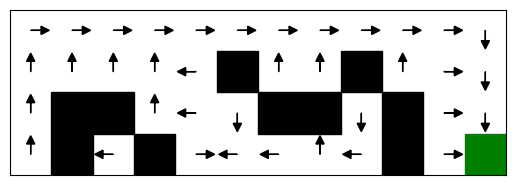

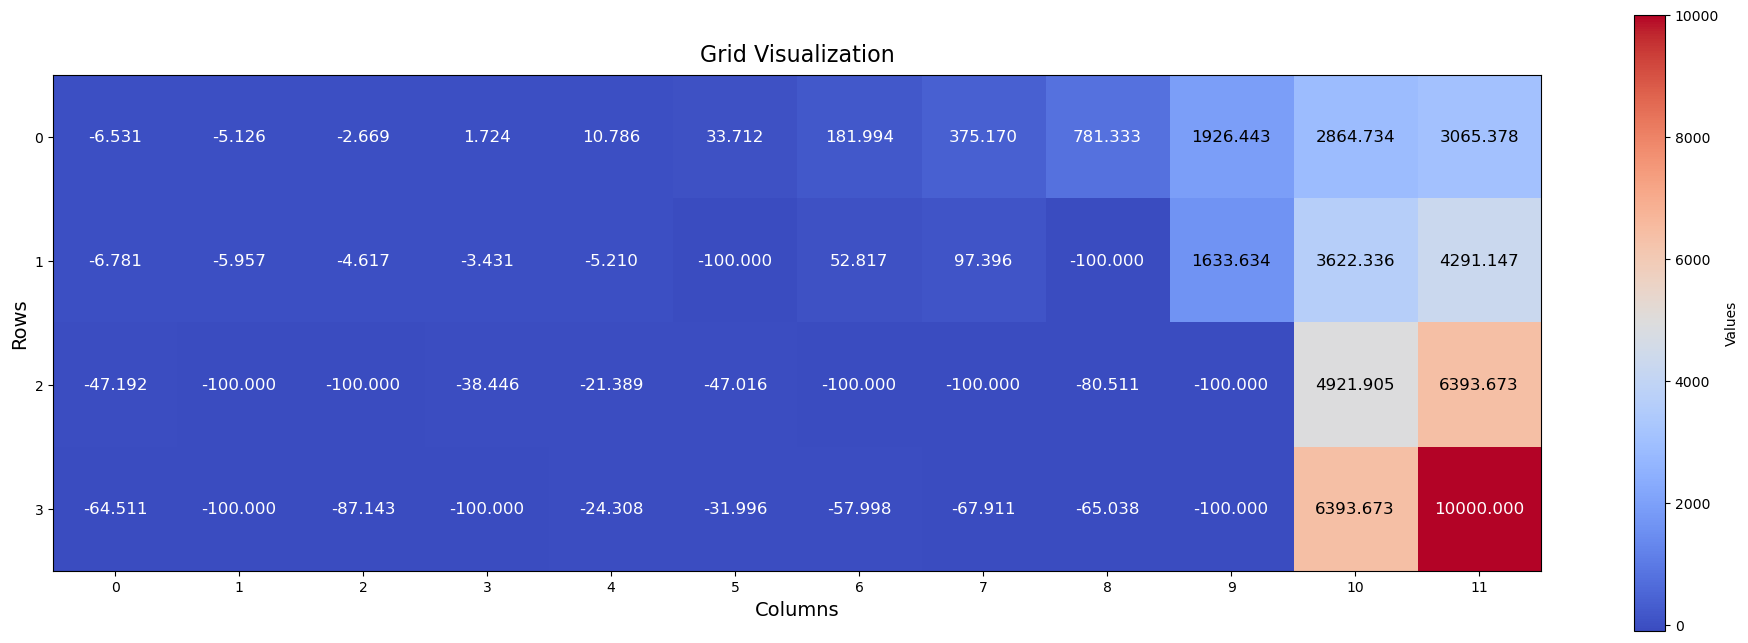

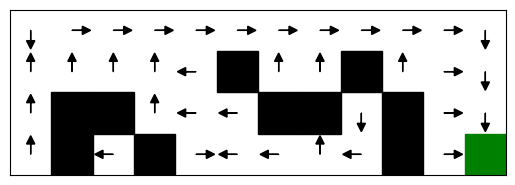

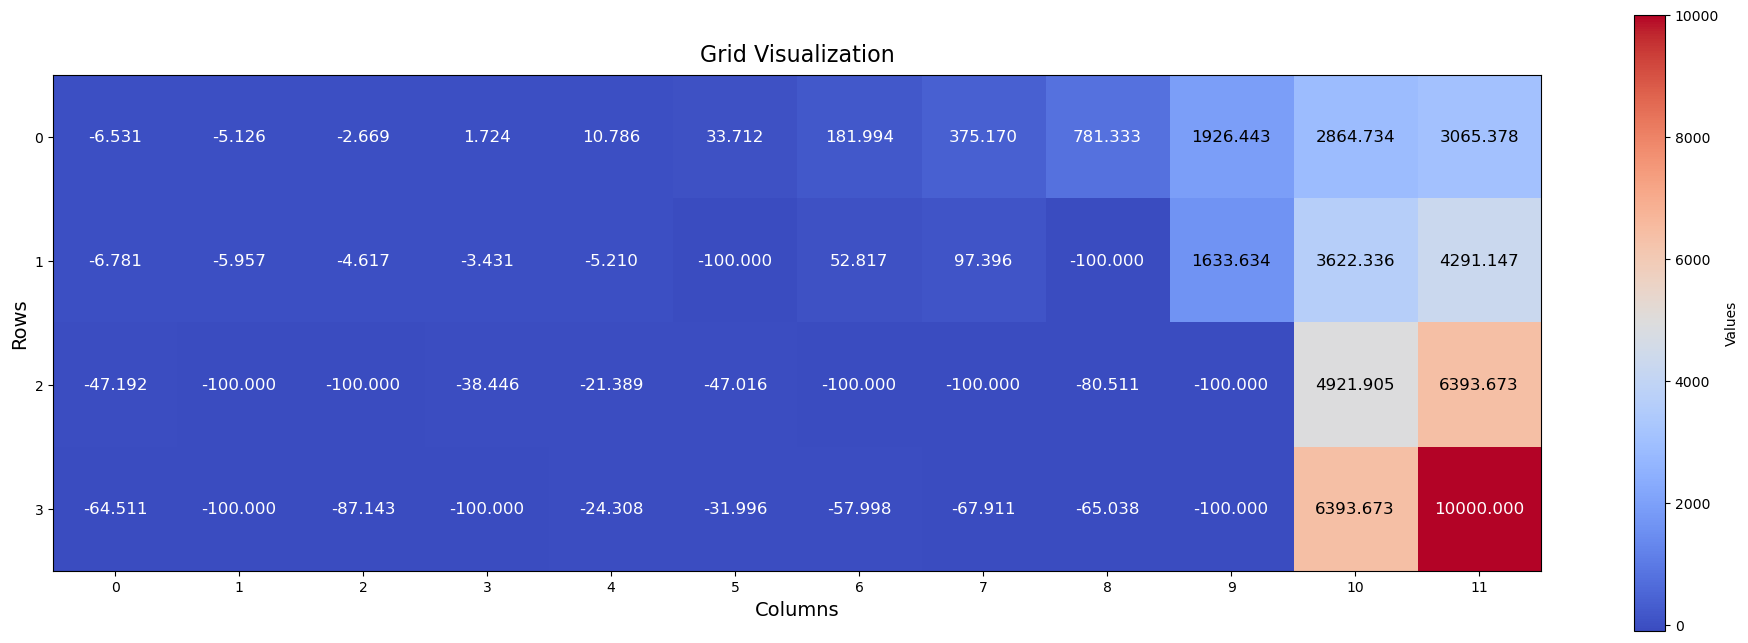

In [7]:
# Create an environment
env = CliffWalking(render_mode="human")
agent = Agent(env)

observation, info = env.reset(seed=30)

terminal_states = [agent.get_s_cell(x) for x in agent.env.cliff_positions]
terminal_states.append(47)

p1, v1, q1, t1, history1 = agent.policy_iteration()
p2, v2, q2, t2, history2 = agent.value_iteration()

# Put the policy to use for the agent
POLICY_TO_RUN = p1

# Shows history of policy and values diagrams 
SHOW_HISTORY = False

print("Algorithm = Policy Iteration")
print(f"number of iterations to convergence {t1}")
draw_grid(p1, terminal_states)
draw_values(v1)

if SHOW_HISTORY:
    print("History: ")
    for hist in history1:
        draw_grid(hist[0], terminal_states)
        draw_values(hist[1])
        print('-------------------------------------')

print('------------------------------------------------------------')

print("Algorithm = Value Iteration")
print(f"number of iterations to convergence {t2}")
draw_grid(p2, terminal_states)
draw_values(v2)

if SHOW_HISTORY:
    print("History: ")
    for hist in history2:
        draw_grid(hist[0], terminal_states)
        draw_values(hist[1])
        print('-------------------------------------')

max_iter_number = 100000
state = observation

# Number of times the agent reaches the goal

success = 0
failed = 0

for __ in range(max_iter_number):
    action = POLICY_TO_RUN[state]
    next_state, reward, done, truncated, info = env.step(action)
    state = next_state

    success += (next_state == 47)
    failed += (reward == -100)

    if done or truncated:
        observation, info = env.reset()
        state = observation

print(f"Success: {success}")
print(f"Failed: {failed}")
print(f"Average steps per episode: {(max_iter_number / (success + failed)) if success + failed != 0 else 'INF'}")

env.close()


In [15]:
def create_policy_gif(history, terminal_states, output_file='policy_history.gif', figsize=(16,8), duration=500, loop=0):
    """
    Create an animated GIF showing only the policy grid from each iteration.

    Parameters:
        history (list): List of tuples (policy, values) generated during iterations.
        terminal_states (list): List of terminal state indices to be passed to draw_grid.
        output_file (str): The output file name for the GIF.
        figsize (tuple): Size of the figure for each frame.
        duration (int): Duration (in milliseconds) between frames.
        loop (int): Number of loops (0 for infinite).
    """
    frames = []
    for i, (policy, _) in enumerate(history):
        # Create a new figure with one axes.
        fig, ax = plt.subplots(figsize=figsize)
        
        # Draw the policy grid using your draw_grid function.
        draw_grid(policy, no_arrow_positions=terminal_states, ax=ax)
        ax.set_title(f"Iteration {i}\nPolicy", fontsize=16)
        
        # Save the figure to an in-memory buffer.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frame = Image.open(buf)
        frames.append(frame)
        
        plt.close(fig)
    
    # Save the list of frames as a GIF.
    frames[0].save(output_file, save_all=True, append_images=frames[1:],
                   duration=duration, loop=loop)
    print(f"Saved policy GIF as {output_file}")

In [16]:
def create_values_gif(history, output_file='values_history.gif', cell_width=2, cell_height=2, figsize=(16,8), duration=500, loop=0):
    """
    Create an animated GIF showing only the values grid from each iteration.

    Parameters:
        history (list): List of tuples (policy, values) generated during iterations.
        output_file (str): The output file name for the GIF.
        cell_width (float): Scaling factor for width for draw_values (ignored if ax is provided).
        cell_height (float): Scaling factor for height for draw_values.
        figsize (tuple): Size of the figure for each frame.
        duration (int): Duration (in milliseconds) between frames.
        loop (int): Number of loops (0 for infinite).
    """
    frames = []
    for i, (_, values) in enumerate(history):
        # Create a new figure with one axes.
        fig, ax = plt.subplots(figsize=figsize)
        
        # Draw the values grid using your draw_values function.
        draw_values(values, cell_width=cell_width, cell_height=cell_height, ax=ax)
        ax.set_title(f"Iteration {i}\nValues", fontsize=16)
        
        # Save the figure to an in-memory buffer.
        buf = io.BytesIO()
        plt.savefig(buf, format='png')
        buf.seek(0)
        frame = Image.open(buf)
        frames.append(frame)
        
        plt.close(fig)
    
    # Save the list of frames as a GIF.
    frames[0].save(output_file, save_all=True, append_images=frames[1:],
                   duration=duration, loop=loop)
    print(f"Saved values GIF as {output_file}")

In [ ]:
# Create the policy GIF.
create_policy_gif(history2, terminal_states, output_file='policy_history2.gif')

# Create the values GIF.
create_values_gif(history2, output_file='values_history2.gif', cell_width=2, cell_height=2)